In [ ]:
""" This notebook explores weight quantization on gpt2 causal model for llm"""
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [ ]:
!pip install -q bitsandbytes>=0.39.0
!pip install -q git+https://github.com/huggingface/accelerate.git
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install accelerate
!pip install bitsandbytes


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [ ]:
torch.manual_seed(0)
device = 'cpu'
model_id = 'gpt2'
model = AutoModelForCausalLM.from_pretrained(model_id).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_id)
print(f"Model size: {model.get_memory_footprint():,} bytes")

Model size: 510,342,192 bytes


In [ ]:
def absmax_quantize(X):
    """
    Quantize and dequantize the input tensor X based on its absolute maximum value.

    :param X: Input tensor.
    :return: Quantized tensor and its dequantized version.
    """
    scale = 127 / torch.max(torch.abs(X))
    X_quant = (scale * X).round()
    X_dequant = X_quant / scale

    return X_quant.to(torch.int8), X_dequant

In [ ]:
def zeropoint_quantize(X):
    """
    Quantize and dequantize the input tensor X using zero-point quantization.

    :param X: Input tensor.
    :return: Quantized tensor and its dequantized version.
    """
    x_range = torch.max(X) - torch.min(X)
    x_range = 1 if x_range == 0 else x_range
    scale = 255 / x_range

    # Shift by zero-point
    zeropoint = (-scale * torch.min(X) - 128).round()
    X_quant = torch.clip((X * scale + zeropoint).round(), -128, 127)

    X_dequant = (X_quant - zeropoint) / scale
    return X_quant.to(torch.int8), X_dequant

In [ ]:
weights = model.transformer.h[0].attn.c_attn.weight.data
print("Original weights:")
print(weights)

weights_abs_quant, _ = absmax_quantize(weights)
print("\nAbsmax quantized weights:")
print(weights_abs_quant)

weights_zp_quant, _ = zeropoint_quantize(weights)
print("\nZero-point quantized weights:")
print(weights_zp_quant)

Original weights:
tensor([[-0.4738, -0.2614, -0.0978,  ...,  0.0513, -0.0584,  0.0250],
        [ 0.0874,  0.1473,  0.2387,  ..., -0.0525, -0.0113, -0.0156],
        [ 0.0039,  0.0695,  0.3668,  ...,  0.1143,  0.0363, -0.0318],
        ...,
        [-0.2592, -0.0164,  0.1991,  ...,  0.0095, -0.0516,  0.0319],
        [ 0.1517,  0.2170,  0.1043,  ...,  0.0293, -0.0429, -0.0475],
        [-0.4100, -0.1924, -0.2400,  ..., -0.0046,  0.0070,  0.0198]])

Absmax quantized weights:
tensor([[-21, -12,  -4,  ...,   2,  -3,   1],
        [  4,   7,  11,  ...,  -2,  -1,  -1],
        [  0,   3,  16,  ...,   5,   2,  -1],
        ...,
        [-12,  -1,   9,  ...,   0,  -2,   1],
        [  7,  10,   5,  ...,   1,  -2,  -2],
        [-18,  -9, -11,  ...,   0,   0,   1]], dtype=torch.int8)

Zero-point quantized weights:
tensor([[-20, -11,  -3,  ...,   3,  -2,   2],
        [  5,   8,  12,  ...,  -1,   0,   0],
        [  1,   4,  18,  ...,   6,   3,   0],
        ...,
        [-11,   0,  10,  ...,  

In [ ]:
weights = [param.data.clone() for param in model.parameters()]

model_abs = deepcopy(model)
weights_abs = []
for param in model_abs.parameters():
    _, dequantized = absmax_quantize(param.data)
    param.data = dequantized
    weights_abs.append(dequantized)

model_zp = deepcopy(model)
weights_zp = []
for param in model_zp.parameters():
    _, dequantized = zeropoint_quantize(param.data)
    param.data = dequantized
    weights_zp.append(dequantized)

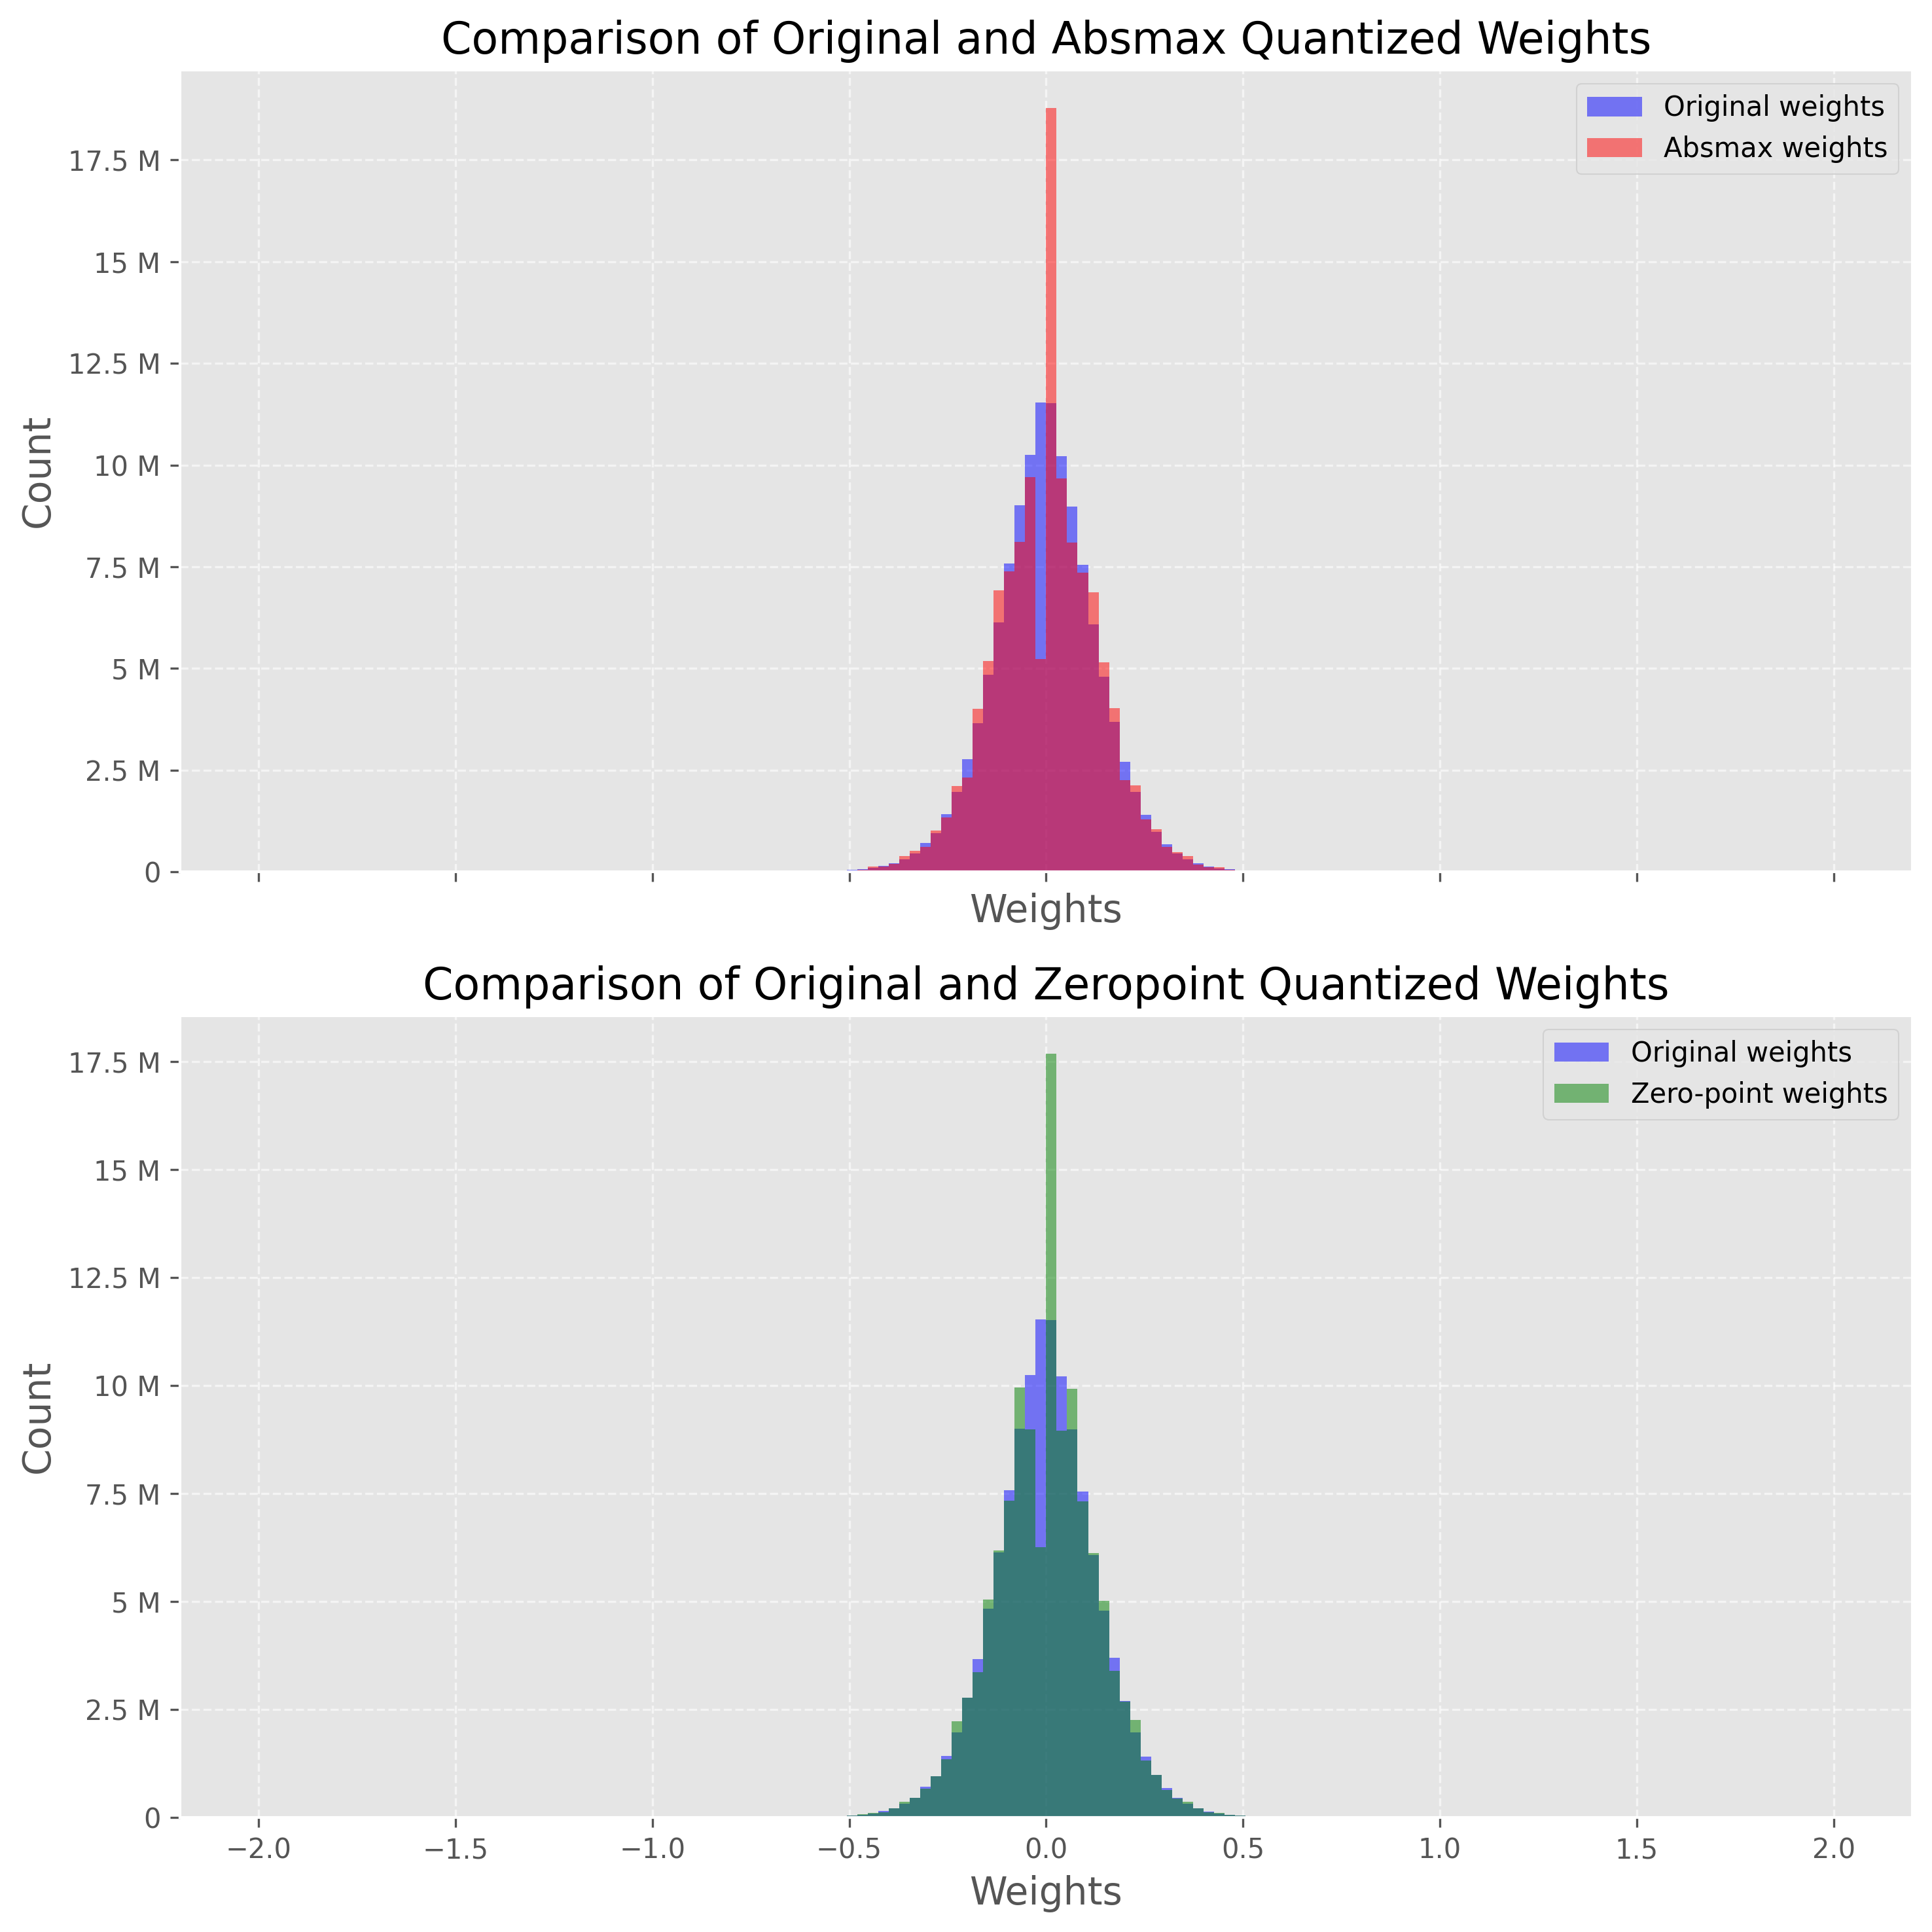

In [ ]:
def plot_weight_histogram(weights, weights_abs, weights_zp):
    """
    Plot histograms comparing original weights with quantized weights.

    :param weights: Original weights.
    :param weights_abs: Absmax quantized weights.
    :param weights_zp: Zero-point quantized weights.
    """
    weights = np.concatenate([t.cpu().numpy().flatten() for t in weights])
    weights_abs = np.concatenate([t.cpu().numpy().flatten() for t in weights_abs])
    weights_zp = np.concatenate([t.cpu().numpy().flatten() for t in weights_zp])

    plt.style.use('ggplot')
    fig, axs = plt.subplots(2, figsize=(10,10), dpi=300, sharex=True)
    axs[0].hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
    axs[0].hist(weights_abs, bins=150, alpha=0.5, label='Absmax weights', color='red', range=(-2, 2))
    axs[1].hist(weights, bins=150, alpha=0.5, label='Original weights', color='blue', range=(-2, 2))
    axs[1].hist(weights_zp, bins=150, alpha=0.5, label='Zero-point weights', color='green', range=(-2, 2))

    for ax in axs:
        ax.grid(True, linestyle='--', alpha=0.6)
    axs[0].legend()
    axs[1].legend()

    axs[0].set_title('Comparison of Original and Absmax Quantized Weights', fontsize=16)
    axs[1].set_title('Comparison of Original and Zeropoint Quantized Weights', fontsize=16)
    for ax in axs:
        ax.set_xlabel('Weights', fontsize=14)
        ax.set_ylabel('Count', fontsize=14)
        ax.yaxis.set_major_formatter(ticker.EngFormatter()) # Make y-ticks more human readable

    plt.rc('font', size=12)

    plt.tight_layout()
    plt.show()


In [ ]:
def generate_text(model, input_text, max_length=50):
    """
    Generate text using the specified model starting from the given input text.

    :param model: The language model used for text generation.
    :param input_text: The starting text for generation.
    :param max_length: The maximum length of the generated text (default is 50).
    :return: The generated text.
    """
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    output = model.generate(inputs=input_ids,
                            max_length=max_length,
                            do_sample=True,
                            top_k=30,
                            pad_token_id=tokenizer.eos_token_id,
                            attention_mask=input_ids.new_ones(input_ids.shape))
    return tokenizer.decode(output[0], skip_special_tokens=True)

In [ ]:
original_text = generate_text(model, "I have a dream")
absmax_text   = generate_text(model_abs, "I have a dream")
zp_text       = generate_text(model_zp, "I have a dream")

print(f"Original model:\n{original_text}")
print("-" * 50)
print(f"Absmax model:\n{absmax_text}")
print("-" * 50)
print(f"Zeropoint model:\n{zp_text}")

Original model:
I have a dream.

What is your dream?

For the past six months I've been studying English literature and writing, but I've been trying for a long time to get back into the literary market. I don't know about
--------------------------------------------------
Absmax model:
I have a dream in my mind, a dream that is beyond belief."
--------------------------------------------------
Zeropoint model:
I have a dream: I could have been a doctor, or I could have been an astronaut, or I could have been in the space program. I could have been an astronaut, or I could have been in the space program. I could have


In [ ]:
def calculate_perplexity(model, text):
    """
    Calculate the perplexity of the given text using the specified language model.

    :param model: The language model used for perplexity calculation.
    :param text: The input text for which perplexity is to be calculated.
    :return: The perplexity value.
    """
    encodings = tokenizer(text, return_tensors='pt').to(device)
    input_ids = encodings.input_ids
    target_ids = input_ids.clone()

    with torch.no_grad():
        outputs = model(input_ids, labels=target_ids)

    neg_log_likelihood = outputs.loss
    ppl = torch.exp(neg_log_likelihood)

    return ppl

In [ ]:
ppl     = calculate_perplexity(model, original_text)
ppl_abs = calculate_perplexity(model_abs, absmax_text)
ppl_zp  = calculate_perplexity(model_zp, absmax_text)

print(f"Original perplexity: {ppl.item():.2f}")
print(f"Absmax perplexity:   {ppl_abs.item():.2f}")
print(f"Zeropoint perplexity: {ppl_zp.item():.2f}")

Original perplexity: 9.45
Absmax perplexity:   21.52
Zeropoint perplexity: 19.38


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_int8 = AutoModelForCausalLM.from_pretrained(model_id,
                                             device_map='auto',
                                             load_in_8bit=True,
                                             )
print(f"Model size: {model_int8.get_memory_footprint():,} bytes")

In [ ]:
weights_int8 = [param.data.clone() for param in model_int8.parameters()]
weights_int8 = np.concatenate([t.cpu().numpy().flatten() for t in weights_int8])
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(10,5), dpi=300)
ax.hist(weights, bins=150, alpha=0.5, label='Original weights',
        color='blue', range=(-2, 2))
ax.hist(weights_int8, bins=150, alpha=0.5, label='LLM.int8() weights',
        color='red', range=(-2, 2))
ax.grid(True, linestyle='--', alpha=0.6)

ax.legend()

ax.set_title('Comparison of Original and Dequantized Weights', fontsize=16)
ax.set_xlabel('Weights', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
plt.gca().yaxis.set_major_formatter(ticker.EngFormatter())
plt.rc('font', size=12)

plt.tight_layout()
plt.show()

In [ ]:
text_int8 = generate_text(model_int8, "I have a dream")

print(f"Original model:\n{original_text}")
print("-" * 50)
print(f"LLM.int8() model:\n{text_int8}")

In [ ]:
rint(f"Perplexity (original):   {ppl.item():.2f}")

ppl = calculate_perplexity(model_int8, text_int8)
print(f"Perplexity (LLM.int8()): {ppl.item():.2f}")